# UFC WINNER PREDICTION

This is a UFC dataset which uses bets and odds to favour who will win a particular fight.
Although originally intended for predicting 'bets', I will be using this to predict who will win the fight.

The following notebook is divided into 3 parts:
1. Baseline model - Building a simple baseline model with basic modifications
2. Data Visualization - Using the power of visualization to gain a deeper insight into our data.
3. Feature Engineering and building the final model - After both the steps above are done, using feature engineering to strengthen our input and build a model more powerful than the baseline

Note: Originally the dataset is built for a **Regression** model, but I have used it to for the purpose of **Classification**.

In [66]:
#Import Cell
#used to import all the libraries and functions used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import sys, warnings, os
from sklearn.dummy import DummyClassifier

In [67]:
#To ignore max-iteration warnings while cross validating scores
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [68]:
#Setting columns and rows to display all the results
pd.set_option("display.max_columns", None, "display.max_rows", None)

In [69]:
#Reading the dataset
ufc_master_ds = pd.read_csv("Resources/ufc-master.csv")
#Seperating label from input
label = ufc_master_ds.Winner
#I have removed "B_Women's Featherweight_rank" because imputing with this feature in the dataset gives me a ton of errors in the baseline model.
X = ufc_master_ds.drop(['Winner',"B_Women's Featherweight_rank"], axis =1)

In [70]:
X.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,R_kd_bout,B_kd_bout,R_sig_str_landed_bout,B_sig_str_landed_bout,R_sig_str_attempted_bout,B_sig_str_attempted_bout,R_sig_str_pct_bout,B_sig_str_pct_bout,R_tot_str_landed_bout,B_tot_str_landed_bout,R_tot_str_attempted_bout,B_tot_str_attempted_bout,R_td_landed_bout,B_td_landed_bout,R_td_attempted_bout,B_td_attempted_bout,R_td_pct_bout,B_td_pct_bout,R_sub_attempts_bout,B_sub_attempts_bout,R_pass_bout,B_pass_bout,R_rev_bout,B_rev_bout
0,Alistair Overeem,Alexander Volkov,150,-182,150.000000,54.945055,2/6/2021,"Las Vegas, Nevada, USA",USA,False,Heavyweight,MALE,5,0,1,0,4.76,0.58,0.2,0.69,0.70,4,2,26,0,0,1,2,3,0,0,6,Orthodox,200.66,203.20,250,0,2,0,3.71,0.64,0.8,1.44,0.56,11,15,83,1,1,0,4,20,8,0,33,Orthodox,193.04,203.20,265,40,32,0,-1,-7,-27,-13,-57,-1,-17,-8,7.62,0.00,-8,1.05,-0.6,-0.75,1,1,6,5,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cory Sandhagen,Frankie Edgar,-400,300,25.000000,300.000000,2/6/2021,"Las Vegas, Nevada, USA",USA,False,Bantamweight,MALE,3,0,1,1,3.70,0.39,0.3,2.28,0.31,5,8,94,9,0,1,10,5,2,0,18,Orthodox,167.64,172.72,135,0,1,0,6.88,0.48,0.5,1.07,0.50,5,1,14,0,0,1,1,3,1,0,6,Switch,180.34,177.80,135,28,39,0,0,0,12,7,80,9,2,1,-12.70,-5.08,11,-3.18,-0.2,1.21,1,1,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alexandre Pantoja,Manel Kape,-125,100,80.000000,100.000000,2/6/2021,"Las Vegas, Nevada, USA",USA,False,Flyweight,MALE,3,0,0,0,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,Southpaw,165.10,172.72,125,1,0,0,4.20,0.47,1.1,1.08,0.36,3,3,21,0,0,1,1,2,2,0,6,Orthodox,165.10,170.18,125,30,27,-1,0,-3,-6,-3,-21,0,-2,-2,0.00,2.54,-3,-4.20,-1.1,-1.08,1,1,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3

# 1. Creating a baseline model

 Since this is a classification task, the target value will be 'Winner'.

***Encoding categorical variables***

I'll be encoding the categorical columns prior to doing anything so it'll be easier for me to split the data while avoiding data leakage.

In [71]:
#Separating the features based on their data types
cat_col = [col for col in X.columns if X[col].dtypes == 'object']
num_col = [col for col in X.columns if col not in cat_col]

In [72]:
enc = LabelEncoder()
for i in X[cat_col]:
    #using astype(str) to avoid columns with 'float and str' to throw errors
    X[i] = enc.fit_transform(X[i].astype(str))

In [73]:
#Also encoding Label for Red to be 1 and Blue to be 0 
label = [1 if win == 'Red' else 0 for win in label]

Now that this is done, I can split the dataset into training and test set.

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X, label, random_state = 2, test_size = 0.3)

***Finding and filling null values***

Building a baseline model would mean imputing all the null values with their 'means' (or mode/ median but I chose mean here) since this is a baseline model

In [75]:
X_train.isnull().sum().sort_values(ascending=False)

R_Women's Featherweight_rank    3184
B_Pound-for-Pound_rank          3173
B_Women's Flyweight_rank        3172
R_Women's Flyweight_rank        3165
B_Women's Strawweight_rank      3157
B_Women's Bantamweight_rank     3150
B_Featherweight_rank            3145
B_Bantamweight_rank             3140
B_Welterweight_rank             3138
B_Lightweight_rank              3137
B_Light Heavyweight_rank        3134
B_Flyweight_rank                3132
B_Heavyweight_rank              3127
B_Middleweight_rank             3127
R_Women's Bantamweight_rank     3121
R_Women's Strawweight_rank      3121
R_Welterweight_rank             3110
R_Featherweight_rank            3110
R_Bantamweight_rank             3109
R_Middleweight_rank             3108
R_Heavyweight_rank              3108
R_Lightweight_rank              3103
R_Flyweight_rank                3101
R_Light Heavyweight_rank        3099
R_Pound-for-Pound_rank          3084
B_kd_bout                       1248
R_kd_bout                       1248
B

Since, it is baseline model, imputation would be pretty basic and simple:
1. Impute the numerical columns with mean
2. Fill the categorical columns with 'most_frequent'

In [76]:
imp = SimpleImputer(strategy='most_frequent')
imp.fit(X_train[num_col])
X_train[num_col] = imp.transform(X_train[num_col])
X_valid[num_col] = imp.transform(X_valid[num_col])

In [77]:
cat_imp = SimpleImputer(strategy = 'most_frequent')
cat_imp.fit(X_train[cat_col])
X_train[cat_col] = cat_imp.transform(X_train[cat_col])
X_valid[cat_col] = cat_imp.transform(X_valid[cat_col])

In [78]:
X_train.sample(10)

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,R_kd_bout,B_kd_bout,R_sig_str_landed_bout,B_sig_str_landed_bout,R_sig_str_attempted_bout,B_sig_str_attempted_bout,R_sig_str_pct_bout,B_sig_str_pct_bout,R_tot_str_landed_bout,B_tot_str_landed_bout,R_tot_str_attempted_bout,B_tot_str_attempted_bout,R_td_landed_bout,B_td_landed_bout,R_td_attempted_bout,B_td_attempted_bout,R_td_pct_bout,B_td_pct_bout,R_sub_attempts_bout,B_sub_attempts_bout,R_pass_bout,B_pass_bout,R_rev_bout,B_rev_bout
2105,553,33,-145,125,68.965517,125.000000,349,140,3,False,6,1,3,0,0,0,0.000000,0.460000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,180.34,175.26,155,0,0,0,0.000000,0.460000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,180.34,180.34,145,23,34,0,0,0,0,0,0,0,0,0,0.00,-5.08,-11,0.000000,0.000000,0.000000,0,1,25,26,7.0,0.0,0.0,13.0,0.0,4.0,0.0,0.0,2.0,10.0,8.0,7.0,6.0,6.0,9.0,7.0,9.0,2.0,8.0,12.0,5.0,4.0,4.0,12.0,14.0,3,7,32,3.0,293,900.0,0.0,0.0,6.0,1.0,10.0,27.0,0.50,0.50,20.0,5.0,33.0,10.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2123,836,341,-275,235,36.363636,235.000000,362,116,21,False,12,0,3,0,0,0,0.000000,0.460000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,152.40,152.40,115,0,1,0,34.000000,0.373333,0.666667,0.333333,0.110000,1,1,7,0,0,0,1,0,1,0,2,1,170.18,170.18,125,24,26,0,-1,-1,-2,1,-7,0,0,-1,-17.78,-17.78,-2,-34.000000,-0.666667,-0.333333,0,1,25,15,7.0,0.0,9.0,13.0,0.0,4.0,0.0,0.0,2.0,10.0,8.0,7.0,6.0,6.0,9.0,7.0,9.0,2.0,8.0,12.0,5.0,4.0,4.0,12.0,14.0,1,4,32,3.0,292,900.0,0.0,0.0,6.0,1.0,10.0,27.0,0.50,0.50,20.0,5.0,33.0,10.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1535,1257,516,-130,120,76.923077,120.000000,80,126,5,False,9,0,3,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,1,0,0,0,0,0,0,0,0,2,167.64,172.72,135,0,0,0,0.000000,0.460000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,172.72,167.64,125,21,29,-1,0,0,0,-1,1,0,0,0,-5.08,5.08,-8,0.000000,0.000000,0.000000,0,1,25,26,7.0,0.0,0.0,13.0,0.0,4.0,0.0,0.0,2.0,10.0,8.0,7.0,6.0,6.0,9.0,7.0,9.0,2.0,8.0,12.0,5.0,4.0,4.0,12.0,14.0,3,7,32,3.0,293,900.0,0.0,0.0,6.0,1.0,10.0,27.0,0.50,0.50,20.0,5.0,33.0,10.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2137,89,315,-135,115,74.074074,115.000000,320,

***Building a baseline model***

In [79]:
#A DummyClassifier is used to be a baseline to compare a better model's performance later on
base_model = DummyClassifier(random_state=2)

In [80]:
base_model.fit(X_train,y_train)

DummyClassifier(random_state=2)

In [81]:
preds = base_model.predict(X_valid)
accuracy_score(y_valid, preds)

0.5240875912408759

49% is the accuracy for this model/ baseline accuracy

Now that the baseline model is built let's focus on building an actual model for our prediction

# 2. Data Visualization
Feature visualization on ufc_master_ds to gain some insight into our data 

In [82]:
ufc_master_ds.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,R_kd_bout,B_kd_bout,R_sig_str_landed_bout,B_sig_str_landed_bout,R_sig_str_attempted_bout,B_sig_str_attempted_bout,R_sig_str_pct_bout,B_sig_str_pct_bout,R_tot_str_landed_bout,B_tot_str_landed_bout,R_tot_str_attempted_bout,B_tot_str_attempted_bout,R_td_landed_bout,B_td_landed_bout,R_td_attempted_bout,B_td_attempted_bout,R_td_pct_bout,B_td_pct_bout,R_sub_attempts_bout,B_sub_attempts_bout,R_pass_bout,B_pass_bout,R_rev_bout,B_rev_bout
0,Alistair Overeem,Alexander Volkov,150,-182,150.000000,54.945055,2/6/2021,"Las Vegas, Nevada, USA",USA,Blue,False,Heavyweight,MALE,5,0,1,0,4.76,0.58,0.2,0.69,0.70,4,2,26,0,0,1,2,3,0,0,6,Orthodox,200.66,203.20,250,0,2,0,3.71,0.64,0.8,1.44,0.56,11,15,83,1,1,0,4,20,8,0,33,Orthodox,193.04,203.20,265,40,32,0,-1,-7,-27,-13,-57,-1,-17,-8,7.62,0.00,-8,1.05,-0.6,-0.75,1,1,6,5,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cory Sandhagen,Frankie Edgar,-400,300,25.000000,300.000000,2/6/2021,"Las Vegas, Nevada, USA",USA,Red,False,Bantamweight,MALE,3,0,1,1,3.70,0.39,0.3,2.28,0.31,5,8,94,9,0,1,10,5,2,0,18,Orthodox,167.64,172.72,135,0,1,0,6.88,0.48,0.5,1.07,0.50,5,1,14,0,0,1,1,3,1,0,6,Switch,180.34,177.80,135,28,39,0,0,0,12,7,80,9,2,1,-12.70,-5.08,11,-3.18,-0.2,1.21,1,1,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alexandre Pantoja,Manel Kape,-125,100,80.000000,100.000000,2/6/2021,"Las Vegas, Nevada, USA",USA,Red,False,Flyweight,MALE,3,0,0,0,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,Southpaw,165.10,172.72,125,1,0,0,4.20,0.47,1.1,1.08,0.36,3,3,21,0,0,1,1,2,2,0,6,Orthodox,165.10,170.18,125,30,27,-1,0,-3,-6,-3,-21,0,-2,-2,0.00,2.54,-3,-4.20,-1.1,-1.08,1,1,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [83]:
#Encoding label so it is easier to find correlation
ufc_master_ds['Winner'] = [1 if winner == 'Red' else 0 for winner in ufc_master_ds.Winner]

Now, let's see the correlation between variables and target and then select the appropriate variable to visualize

In [84]:
num_corr_col = [col for col in ufc_master_ds.columns if ufc_master_ds[col].dtype == 'int64' or ufc_master_ds[col].dtype == 'float64']
corr_dict = {}
#Getting absolute values of correlation since we would need to inspect negative correlation too
for col in num_corr_col:
    corr_dict[col] = abs(ufc_master_ds[col].corr(ufc_master_ds['Winner']))

In [85]:
for w in sorted(corr_dict, key=corr_dict.get):
    print(w, corr_dict[w])

B_Pound-for-Pound_rank 4.0438642413036e-18
B_avg_SUB_ATT 0.0006736112614573917
B_avg_TD_pct 0.0009201808895340086
R_Welterweight_rank 0.0012701269778216627
B_win_by_Submission 0.0017995641358488264
R_win_by_Decision_Unanimous 0.002687505760424579
total_title_bout_dif 0.003499821552798515
B_longest_win_streak 0.004181782202401373
R_Weight_lbs 0.005904824770245006
R_Height_cms 0.005970663201641085
R_win_by_Submission 0.006133959910974233
sub_dif 0.006449232915702231
R_draw 0.007935935240262116
B_win_by_TKO_Doctor_Stoppage 0.009936743234671318
R_rev_bout 0.01052663529382445
B_avg_SIG_STR_pct 0.010679686254663581
R_Pound-for-Pound_rank 0.010723703312317751
R_wins 0.010795991776121673
B_Middleweight_rank 0.010808014397003114
B_wins 0.011037180629812016
R_Reach_cms 0.012441208177052288
R_win_by_KO/TKO 0.012514062387041855
empty_arena 0.013754836001593093
B_win_by_Decision_Majority 0.013951715582271667
B_win_by_Decision_Unanimous 0.015089180046768083
R_win_by_Decision_Majority 0.0159562117792

The biggest contributors i.e. columns with a greater than 0.25 correlation (in increasing order of importance) are:
* B_td_landed_bout,
* R_td_pct_bout,
* B_sig_str_landed_bout,
* B_tot_str_landed_bout,
* R_tot_str_landed_bout,
* R_pass_bout,
* R_kd_bout,
* B_sig_str_pct_bout,
* B_pass_bout,
* B_ev,
* R_ev,
* R_odds,
* B_odds,
* R_sig_str_pct_bout,
* B_kd_bout

Since none of the bout variables have any information on them, I'll have to do some inspection and visualization and see if I can find out the meaning of these.

In [86]:
ufc_master_ds['B_kd_bout'].unique()

array([nan,  0.,  1.,  2.,  3.,  4.])

In [87]:
#Getting null values percentage
(ufc_master_ds['B_kd_bout'].isnull().sum()/ufc_master_ds.shape[0])*100

39.2904073587385

More than 38% of these values are null

In [88]:
#For visualization purposes
ufc_master_ds['Winner'] = ['Red' if winner == 1 else 'Blue' for winner in ufc_master_ds.Winner]

Let's see the countplot

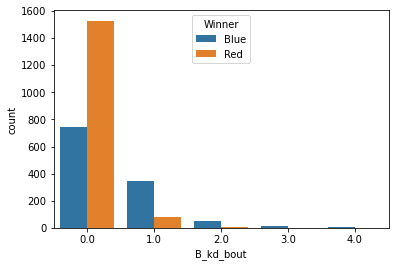

In [89]:
sns.countplot(x=ufc_master_ds['B_kd_bout'], hue = ufc_master_ds['Winner']);

A majority of these values belong to 0, then 1,2,3 with a rare appearance in 4. All belong to float64 type. Also, these are bout related.

According to the official UFC site, 'kd' refers to knockdown, so these could be knockdowns dealt to/by the blue player

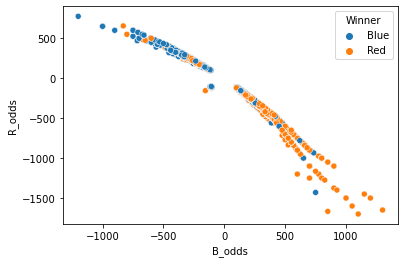

In [90]:
#Analysing "_odds" variables
sns.scatterplot(x="B_odds", y="R_odds", hue="Winner", data = ufc_master_ds);

As B_odds increase, there are more "Red" winners. Same for blue, so it seems that, with the exception of a few outliers, all of the winner are the ones that are bet against. These seem like odds to lose rather than odds to win

In [91]:
#Just to be sure
ufc_master_ds["Winner"].loc[ufc_master_ds["B_odds"]>1].value_counts()

Red     1943
Blue     869
Name: Winner, dtype: int64

These are the winner distributions where the odds of Blue player winning are greater than 0, but the winners are clearly Red players.
Same would be applicable for B_odds

In [92]:
#Null values in _sig_str_pct_bout variables
[(ufc_master_ds[col].isnull().sum()/ufc_master_ds.shape[0])*100 for col in ['R_sig_str_pct_bout','B_sig_str_pct_bout']]
#Same number of missing values as _kd_bout variables

[39.2904073587385, 39.2904073587385]

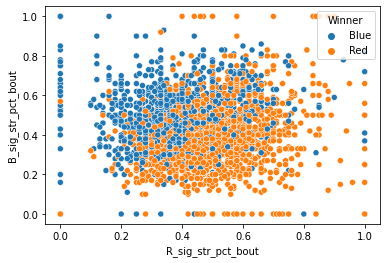

In [93]:
sns.scatterplot(x='R_sig_str_pct_bout',y='B_sig_str_pct_bout',hue = 'Winner', data=ufc_master_ds);

There does seem to be somewhat of a linear correlation in significant striking accuracy and winner of the bout

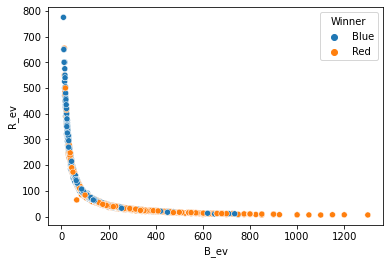

In [94]:
#Lets inspect _ev variables
sns.scatterplot(x='B_ev', y='R_ev',hue = 'Winner', data=ufc_master_ds);

When B_ev is increasing in value, the winners are Red and when R_ev is increasing, the winners are Blue.

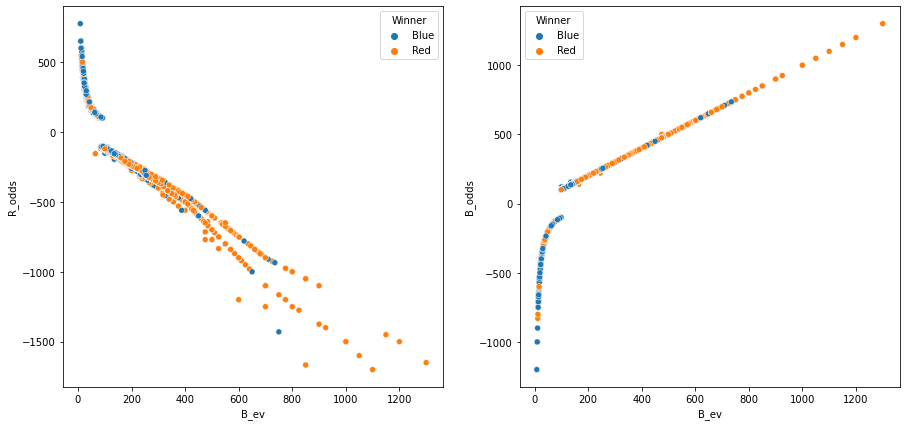

In [95]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.scatterplot(x='B_ev', y='R_odds',hue = 'Winner', data=ufc_master_ds, ax=ax[0]);
sns.scatterplot(x='B_ev', y='B_odds',hue = 'Winner', data=ufc_master_ds, ax=ax[1]);
fig.show()

As the chances of Red winning increases (i.e. R_odds decreases), the profit i.e. B_ev increases.
This indicates that B_ev is the profit on Red rather than blue and the other way round would be the same for R_ev

The _bout features would have more or less similar relationship with one another

Let's move to _Stance variables

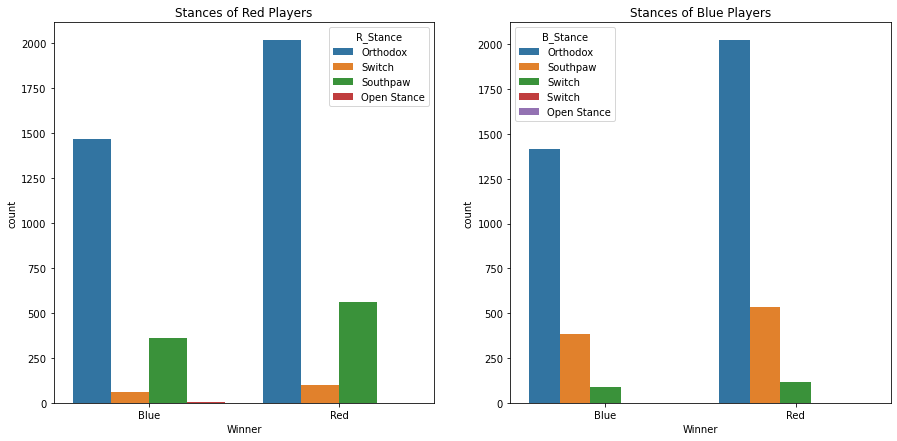

In [96]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.countplot(ufc_master_ds['Winner'], hue = ufc_master_ds['R_Stance'], ax=ax[0])
sns.countplot(ufc_master_ds['Winner'], hue = ufc_master_ds['B_Stance'], ax=ax[1])
ax[0].title.set_text('Stances of Red Players')
ax[1].title.set_text('Stances of Blue Players')
fig.show()

Orthodox is the superior stance followed by Southpaw and then Switch

# 3. Feature Engineering, Filling null values and Final Model

In [97]:
ufc_master_ds.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,R_kd_bout,B_kd_bout,R_sig_str_landed_bout,B_sig_str_landed_bout,R_sig_str_attempted_bout,B_sig_str_attempted_bout,R_sig_str_pct_bout,B_sig_str_pct_bout,R_tot_str_landed_bout,B_tot_str_landed_bout,R_tot_str_attempted_bout,B_tot_str_attempted_bout,R_td_landed_bout,B_td_landed_bout,R_td_attempted_bout,B_td_attempted_bout,R_td_pct_bout,B_td_pct_bout,R_sub_attempts_bout,B_sub_attempts_bout,R_pass_bout,B_pass_bout,R_rev_bout,B_rev_bout
0,Alistair Overeem,Alexander Volkov,150,-182,150.000000,54.945055,2/6/2021,"Las Vegas, Nevada, USA",USA,Blue,False,Heavyweight,MALE,5,0,1,0,4.76,0.58,0.2,0.69,0.70,4,2,26,0,0,1,2,3,0,0,6,Orthodox,200.66,203.20,250,0,2,0,3.71,0.64,0.8,1.44,0.56,11,15,83,1,1,0,4,20,8,0,33,Orthodox,193.04,203.20,265,40,32,0,-1,-7,-27,-13,-57,-1,-17,-8,7.62,0.00,-8,1.05,-0.6,-0.75,1,1,6,5,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cory Sandhagen,Frankie Edgar,-400,300,25.000000,300.000000,2/6/2021,"Las Vegas, Nevada, USA",USA,Red,False,Bantamweight,MALE,3,0,1,1,3.70,0.39,0.3,2.28,0.31,5,8,94,9,0,1,10,5,2,0,18,Orthodox,167.64,172.72,135,0,1,0,6.88,0.48,0.5,1.07,0.50,5,1,14,0,0,1,1,3,1,0,6,Switch,180.34,177.80,135,28,39,0,0,0,12,7,80,9,2,1,-12.70,-5.08,11,-3.18,-0.2,1.21,1,1,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alexandre Pantoja,Manel Kape,-125,100,80.000000,100.000000,2/6/2021,"Las Vegas, Nevada, USA",USA,Red,False,Flyweight,MALE,3,0,0,0,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,Southpaw,165.10,172.72,125,1,0,0,4.20,0.47,1.1,1.08,0.36,3,3,21,0,0,1,1,2,2,0,6,Orthodox,165.10,170.18,125,30,27,-1,0,-3,-6,-3,-21,0,-2,-2,0.00,2.54,-3,-4.20,-1.1,-1.08,1,1,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Considering the number of variables, it would make sense to combine similar variables to increase their correlation and reduce complexity by limiting the input features

Some variables are already engineered. They have combined features, so I'll just be doing those that haven't yet been touched.
These are the already engineered features:
1. lose_streak_dif: (Blue lose streak) - (Red lose streak) 
2. winstreakdif: (Blue win streak) - (Red win streak)
3. longest_win_streak_dif: (Blue longest win streak) - (Red longest win streak)
4. win_dif: (Blue wins) - (Red wins)
5. loss_dif: (Blue losses) - (Red losses)
6. total_round_dif: (Blue total rounds fought) - (Red total rounds fought)
7. total_title_bout_dif: (Blue number of title fights) - (Red number of title fights)
8. ko_dif: (Blue wins by KO/TKO) - (Red wins by KO/TKO)
9. sub_dif: (Blue wins by submission) - (Red wins by submission)
10. height_dif: (Blue height) - (Red height) in cms
11. reach_dif: (Blue reach) - (Red reach) in cms
12. age_dif: (Blue age) - (Red age)
13. sig_str_dif: (Blue sig strikes per minute) - (Red sig strikes per minute)
14. avg_sub_att_dif: (Blue submission attempts) - (Red submission attempts)
15. avg_td_dif: (Blue TD attempts) - (Red TD attempts)

In [98]:
ufc_master_ds['draw_diff'] = (ufc_master_ds['B_draw']-ufc_master_ds['R_draw'])
ufc_master_ds['avg_sig_str_pct_diff'] = (ufc_master_ds['B_avg_SIG_STR_pct']-ufc_master_ds['R_avg_SIG_STR_pct'])
ufc_master_ds['avg_TD_pct_diff'] = (ufc_master_ds['B_avg_TD_pct']-ufc_master_ds['B_avg_TD_pct'])
ufc_master_ds['win_by_Decision_Majority_diff'] = (ufc_master_ds['B_win_by_Decision_Majority']-ufc_master_ds['R_win_by_Decision_Majority'])
ufc_master_ds['win_by_Decision_Split_diff'] = (ufc_master_ds['B_win_by_Decision_Split']-ufc_master_ds['R_win_by_Decision_Split'])
ufc_master_ds['win_by_Decision_Unanimous_diff'] = (ufc_master_ds['B_win_by_Decision_Unanimous']-ufc_master_ds['R_win_by_Decision_Unanimous'])
ufc_master_ds['win_by_TKO_Doctor_Stoppage_diff'] = (ufc_master_ds['B_win_by_TKO_Doctor_Stoppage']-ufc_master_ds['R_win_by_TKO_Doctor_Stoppage'])

In [99]:
ufc_master_ds['odds_diff'] = (ufc_master_ds['B_odds']-ufc_master_ds['R_odds'])
ufc_master_ds['ev_diff'] = (ufc_master_ds['B_ev']-ufc_master_ds['R_ev'])

ufc_master_ds['kd_bout_diff']=(ufc_master_ds['B_kd_bout']-ufc_master_ds['R_kd_bout'])
ufc_master_ds['sig_str_landed_bout_diff']=(ufc_master_ds['B_sig_str_landed_bout']-ufc_master_ds['R_sig_str_landed_bout'])
ufc_master_ds['sig_str_attempted_bout_diff']=(ufc_master_ds['B_sig_str_attempted_bout']-ufc_master_ds['R_sig_str_attempted_bout'])
ufc_master_ds['sig_str_attempted_bout_diff']=(ufc_master_ds['B_sig_str_attempted_bout']-ufc_master_ds['R_sig_str_attempted_bout'])
ufc_master_ds['sig_str_pct_bout_diff']=(ufc_master_ds['B_sig_str_pct_bout']-ufc_master_ds['R_sig_str_pct_bout'])
ufc_master_ds['tot_str_landed_bout_diff']=(ufc_master_ds['B_tot_str_landed_bout']-ufc_master_ds['R_tot_str_landed_bout'])
ufc_master_ds['tot_str_attempted_bout_diff']=(ufc_master_ds['B_tot_str_attempted_bout']-ufc_master_ds['R_tot_str_attempted_bout'])
ufc_master_ds['td_landed_bout_diff']=(ufc_master_ds['B_td_landed_bout']-ufc_master_ds['R_td_landed_bout'])
ufc_master_ds['td_attempted_bout_diff']=(ufc_master_ds['B_td_attempted_bout']-ufc_master_ds['R_td_attempted_bout'])
ufc_master_ds['td_pct_bout_diff']=(ufc_master_ds['B_td_pct_bout']-ufc_master_ds['R_td_pct_bout'])
ufc_master_ds['td_pct_bout_diff']=(ufc_master_ds['B_td_pct_bout']-ufc_master_ds['R_td_pct_bout'])
ufc_master_ds['sub_attempts_bout_diff']=(ufc_master_ds['B_sub_attempts_bout']-ufc_master_ds['R_sub_attempts_bout'])
ufc_master_ds['pass_bout_diff']=(ufc_master_ds['B_pass_bout']-ufc_master_ds['R_pass_bout'])
ufc_master_ds['rev_bout_diff']=(ufc_master_ds['B_rev_bout']-ufc_master_ds['R_rev_bout'])

After extracting the necessary information from these variables, there's no more need for them. So, I'll just drop them

In [100]:
#Dropping variables
var_drop = [
'B_odds',
'R_odds',
'B_ev',
'R_ev',
'R_kd_bout',
'B_kd_bout',
'R_sig_str_landed_bout',
'B_sig_str_landed_bout',
'R_sig_str_attempted_bout',
'B_sig_str_attempted_bout',
'R_sig_str_pct_bout',
'B_sig_str_pct_bout',
'R_tot_str_landed_bout',
'B_tot_str_landed_bout',
'R_tot_str_attempted_bout',
'B_tot_str_attempted_bout',
'R_td_landed_bout',
'B_td_landed_bout',
'R_td_attempted_bout',
'B_td_attempted_bout',
'R_td_pct_bout',
'B_td_pct_bout',
'R_sub_attempts_bout',
'B_sub_attempts_bout',
'R_pass_bout',
'B_pass_bout',
'R_rev_bout',
'B_rev_bout',
'B_current_lose_streak', 'R_current_lose_streak',
'B_current_win_streak', 'R_current_win_streak',
'B_longest_win_streak', 'R_longest_win_streak',
'B_wins', 'R_wins',
'B_losses', 'R_losses',
'B_total_rounds_fought', 'R_total_rounds_fought',
'B_total_title_bouts', 'R_total_title_bouts',
'B_win_by_KO/TKO', 'R_win_by_KO/TKO',
'B_win_by_Submission', 'R_win_by_Submission',
'B_Height_cms', 'R_Height_cms',
'B_Reach_cms', 'R_Reach_cms',
'B_age', 'R_age',
'B_avg_SIG_STR_landed', 'R_avg_SIG_STR_landed',
'B_avg_SUB_ATT', 'R_avg_SUB_ATT',
'B_avg_TD_landed', 'R_avg_TD_landed',
'B_draw','B_avg_SIG_STR_pct','B_avg_TD_pct','B_win_by_Decision_Majority','B_win_by_Decision_Split','B_win_by_Decision_Unanimous','B_win_by_TKO_Doctor_Stoppage',
'R_draw','R_avg_SIG_STR_pct','R_avg_TD_pct','R_win_by_Decision_Majority','R_win_by_Decision_Split','R_win_by_Decision_Unanimous','R_win_by_TKO_Doctor_Stoppage']
ufc_master_ds.drop(var_drop, axis=1, inplace = True)

Next step will be dropping the variables that are common to both the fighters(like date, country, etc.) and thus provide no advantage to anyone

In [101]:
comm_drop = [
'date','location','country','weight_class','gender','no_of_rounds','empty_arena','constant_1','finish','finish_details','finish_round','finish_round_time','total_fight_time_secs','B_Weight_lbs','R_Weight_lbs'
]
ufc_master_ds.drop(comm_drop, axis=1, inplace = True)

Before moving on to the rank variables, the _Stance variables need some encoding. I'll encode them as I visualized them above.i.e. Orthodox is superior so it will be 4, Southpaw after that will be 3, Switch, 2, and Open Stance 1

In [102]:
ufc_master_ds.B_Stance.unique()

array(['Orthodox', 'Southpaw', 'Switch', 'Switch ', 'Open Stance'],
      dtype=object)

In [103]:
#It has one spelling mistake
ufc_master_ds['B_Stance'].loc[ufc_master_ds['B_Stance']=='Switch '] = 'Switch'
#R_Stance doesn't have this error, so we're cool

In [104]:
stance = ['B_Stance', 'R_Stance']

In [105]:
for x in stance:
    ufc_master_ds[x] = [4 if st == 'Orthodox'
                           else 3 if st == 'Southpaw'
                           else 2 if st == 'Switch'
                           else 1 for st in ufc_master_ds[x]]
#using -1 and 1 for both red and blue so there is no misunderstanding that one variable is better than the other    
ufc_master_ds['better_rank'] = [-1 if rank == 'Red'
                               else 1 if rank == 'Blue'
                               else 0 for rank in ufc_master_ds['better_rank']]

ufc_master_ds['title_bout'] = [1 if tb==True else 0 for tb in ufc_master_ds['title_bout']]

In [106]:
ufc_master_ds['Stance_diff'] = (ufc_master_ds['B_Stance'] - ufc_master_ds['R_Stance'])
ufc_master_ds.drop(stance, axis = 1, inplace = True)

In [107]:
ufc_master_ds.head()

,R_fighter,B_fighter,Winner,title_bout,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,draw_diff,avg_sig_str_pct_diff,avg_TD_pct_diff,win_by_Decision_Majority_diff,win_by_Decision_Split_diff,win_by_Decision_Unanimous_diff,win_by_TKO_Doctor_Stoppage_diff,odds_diff,ev_diff,kd_bout_diff,sig_str_landed_bout_diff,sig_str_attempted_bout_diff,sig_str_pct_bout_diff,tot_str_landed_bout_diff,tot_str_attempted_bout_diff,td_landed_bout_diff,td_attempted_bout_diff,td_pct_bout_diff,sub_attempts_bout_diff,pass_bout_diff,rev_bout_diff,Stance_diff
0,Alistair Overeem,Alexander Volkov,Blue,0,0,-1,-7,-27,-13,-57,-1,-17,-8,7.62,0.00,-8,1.05,-0.6,-0.75,6,5,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,-0.06,0.0,-1,1,-2,0,-332,-95.054945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Cory Sandhagen,Frankie Edgar,Red,0,0,0,0,12,7,80,9,2,1,-12.70,-5.08,11,-3.18,-0.2,1.21,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,-1,1,-0.09,0.0,0,0,9,0,700,275.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,Alexandre Pantoja,Manel Kape,Red,0,-1,0,-3,-6,-3,-21,0,-2,-2,0.00,2.54,-3,-4.20,-1.1,-1.08,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,-0.47,0.0,0,-1,-1,0,225,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,Diego Ferreira,Beneil Dariush,Blue,0,0,-1,-1,5,2,15,0,0,3,2.54,-5.08,-5,-1.09,0.1,0.71,13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,-1,1,0.13,0.0,0,1,1,0,230,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,Michael Johnson,Clay Guida,Blue,0,-1,0,0,6,3,29,0,-2,4,-7.62,-7.62,5,-1.82,0.6,2.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.05,0.0,0,2,2,0,400,130.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [108]:
#Encoding label so it is easier to find correlation
ufc_master_ds['Winner'] = [1 if winner == 'Red' else 0 for winner in ufc_master_ds.Winner]

In [109]:
ufc_master_ds.loc[:,'B_match_weightclass_rank':'better_rank'].isnull().sum()

B_match_weightclass_rank        3754
R_match_weightclass_rank        3333
R_Women's Flyweight_rank        4516
R_Women's Featherweight_rank    4553
R_Women's Strawweight_rank      4470
R_Women's Bantamweight_rank     4457
R_Heavyweight_rank              4433
R_Light Heavyweight_rank        4434
R_Middleweight_rank             4445
R_Welterweight_rank             4435
R_Lightweight_rank              4438
R_Featherweight_rank            4441
R_Bantamweight_rank             4438
R_Flyweight_rank                4432
R_Pound-for-Pound_rank          4418
B_Women's Flyweight_rank        4532
B_Women's Featherweight_rank    4566
B_Women's Strawweight_rank      4511
B_Women's Bantamweight_rank     4492
B_Heavyweight_rank              4464
B_Light Heavyweight_rank        4479
B_Middleweight_rank             4476
B_Welterweight_rank             4484
B_Lightweight_rank              4484
B_Featherweight_rank            4482
B_Bantamweight_rank             4486
B_Flyweight_rank                4476
B

Almost all of _rank variables except better_rank are empty. I'll keep it and remove the rest

In [110]:
ufc_master_ds.drop(ufc_master_ds.loc[:,'B_match_weightclass_rank':'B_Pound-for-Pound_rank'], axis=1, inplace = True)

In [111]:
ufc_master_ds.sample(10)

,R_fighter,B_fighter,Winner,title_bout,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,better_rank,draw_diff,avg_sig_str_pct_diff,avg_TD_pct_diff,win_by_Decision_Majority_diff,win_by_Decision_Split_diff,win_by_Decision_Unanimous_diff,win_by_TKO_Doctor_Stoppage_diff,odds_diff,ev_diff,kd_bout_diff,sig_str_landed_bout_diff,sig_str_attempted_bout_diff,sig_str_pct_bout_diff,tot_str_landed_bout_diff,tot_str_attempted_bout_diff,td_landed_bout_diff,td_attempted_bout_diff,td_pct_bout_diff,sub_attempts_bout_diff,pass_bout_diff,rev_bout_diff,Stance_diff
531,Trevin Giles,Gerald Meerschaert,0,0,-1,0,0,2,-2,4,0,-1,3,2.54,7.62,-4,-0.880000,1.600000,1.090000,0,0,-0.140000,0.0,0,0,0,0,320,91.176471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1271,Ji Yeon Kim,Melinda Fabian,1,0,-1,-1,-1,-1,0,-3,0,0,0,-2.54,-15.24,-2,-15.000000,0.000000,0.000000,0,0,0.070000,0.0,0,-1,0,0,320,91.176471,0.0,-1.0,-68.0,0.11,-14.0,-81.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2658,Ben Rothwell,Matt Mitrione,1,0,0,1,3,5,0,4,0,5,0,-2.54,2.54,-3,0.452381,0.047619,-1.000000,-1,0,0.097024,0.0,0,0,0,0,-310,-84.393939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2
469,Amanda Nunes,Holly Holm,1,1,0,-7,-5,-6,-2,8,-1,-5,-2,0.00,0.00,-6,-1.590000,-0.600000,-1.830000,-1,0,-0.140000,0.0,0,0,1,0,660,272.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1194,Alex Perez,Jose Torres,1,0,0,-1,-1,-1,0,-3,0,1,-1,-5.08,0.00,0,-4.500000,-1.500000,-2.500000,0,0,-0.125000,0.0,0,0,-1,0,220,16.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2618,Gunnar Nelson,Brandon Thatch,1,0,0,0,-2,-2,0,-6,0,2,-3,7.62,5.08,-3,-2.266667,-0.800000,-0.200000,-1,0,-0.193333,0.0,0,0,-1,0,-320,-91.176471,-1.0,2.0,6.0,-0.18,-12.0,-10.0,0.0,0.0,0.0,-1.0,-3.0,0.0,0
4257,Rampage Jackson,Matt Hamill,1,0,0,4,2,3,0,0,-3,2,0,0.00,7.62,-2,-1.465909,0.000000,1.375000,0,0,-0.088750,0.0,1,-1,0,0,580,242.213115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4392,Duane Ludwig,Nick Osipczak,1,0,0,0,0,0,0,4,0,0,1,10.16,15.24,7,18.750000,1.000000,0.750000,0,0,0.022500,0.0,0,0,-1,0,-620,-250.588235,2.0,-39.0,-121.0,0.12,-22.0,-103.0,2.0,1.0,0.4,0.0,1.0,0.0,0
778,Valentina Shevchenko,Jessica Eye,1,1,0,1,1,-1,-4,4,-2,1,-2,2.54,0.00,-1,-8.128571,0.271429,-1.928571,-1,0,-0.176714,0.0,0,1,-1,1,1800,690.909091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2757,Gray Maynard,Alexander Yakovlev,0,0,1,0,-8,-9,4,-36,-2,-1,0,15.24,10.16,5,6.266667,-0.600000,-1.766667,0,0,0.096000,0.0,0,-3,-5,0,-260,-48.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [112]:
label = ufc_master_ds.Winner
ufc_master_ds.drop(['Winner'], axis=1, inplace = True)

In [113]:
#Encoding the remaining categorical variables
cat_col = ['R_fighter', 'B_fighter']
enc = LabelEncoder()
for i in ufc_master_ds[cat_col]:
    ufc_master_ds[i] = enc.fit_transform(ufc_master_ds[i])

***Splitting the data in training and testing data set***

In [114]:
X_train, X_valid, y_train, y_valid = train_test_split(ufc_master_ds, label, test_size = 0.3, random_state=2)

In [115]:
#At this point all the null values are the ones that have been left empty by error/mistake and are not left empty deliberately.
#So, it would make sense to fill in these with mean rather than 0 or anything else
impute = SimpleImputer(strategy = 'mean')
impute.fit(X_train)
X_train = impute.transform(X_train)
X_valid = impute.transform(X_valid)

In [116]:
RF_model = RandomForestClassifier(random_state=2)

In [117]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(random_state=2)

In [118]:
preds = RF_model.predict(X_valid)
accuracy_score(y_valid, preds)

0.7708029197080292

**77% is the accuracy after feature engineering**

In [119]:
#Built a model after doing GridSearch but not putting the code here because the cell takes up a lot of time
RF_model = RandomForestClassifier(n_estimators = 350, max_depth = 12, random_state = 2)

In [120]:
RF_model.fit(X_train, y_train)
preds = RF_model.predict(X_valid)
accuracy_score(y_valid, preds)

0.7722627737226277

**77.9% which is almost 78% accuracy**

So, after careful feature engineering and data visualization, the accuracy of our model increased by almost 30%.

Note : It should be considered that the model used as a baseline was a DummyClassifier and not a proper model.


In [124]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')

In [123]:
ufc_master_ds.to_csv(index=False)


'R_fighter,B_fighter,title_bout,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,better_rank,draw_diff,avg_sig_str_pct_diff,avg_TD_pct_diff,win_by_Decision_Majority_diff,win_by_Decision_Split_diff,win_by_Decision_Unanimous_diff,win_by_TKO_Doctor_Stoppage_diff,odds_diff,ev_diff,kd_bout_diff,sig_str_landed_bout_diff,sig_str_attempted_bout_diff,sig_str_pct_bout_diff,tot_str_landed_bout_diff,tot_str_attempted_bout_diff,td_landed_bout_diff,td_attempted_bout_diff,td_pct_bout_diff,sub_attempts_bout_diff,pass_bout_diff,rev_bout_diff,Stance_diff\r\n58,53,0,0,-1,-7,-27,-13,-57,-1,-17,-8,7.62,0.0,-8,1.05,-0.6,-0.75,-1,0,-0.06000000000000005,0.0,-1,1,-2,0,-332,-95.05494505,,,,,,,,,,,,,0\r\n262,485,0,0,0,0,12,7,80,9,2,1,-12.7,-5.08,11,-3.18,-0.2,1.21,-1,1,-0.08999999999999997,0.0,0,0,9,0,700,275.0,,,,,,,,,,,,,2\r\n53,923,0,-1,0,-3,-6,-3,-21,0,-2,-2,0.0,2.54,-

In [126]:
ufc_master_ds.to_csv('out.zip', index=False,
          compression=compression_opts)  

In [ ]:
ufc_master_ds.to_csv(index=False)


In [128]:
ufc_master_ds.to_csv('out2.zip', index=True,
          compression=compression_opts)  